# Download dataset from kaggle

Install kaggle


In [5]:
!pip3 install -q kaggle

Mount the **gdrive**


In [33]:
# from google.colab import drive
# drive.mount('/content/gdrive')
models_drive_folder = "./models"

Colab requires the file to be placed in /.kaggle


In [3]:
!mkdir -p ~/.kaggle
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Take ownership of the kaggle.json file


Download the dataset


In [4]:
!kaggle datasets download -d grassknoted/asl-alphabet

100%|█████████████████████████████████████▉| 1.02G/1.03G [00:40<00:00, 30.3MB/s]
100%|██████████████████████████████████████| 1.03G/1.03G [00:40<00:00, 27.1MB/s]


In [5]:
import zipfile

FILENAME = "./asl-alphabet.zip"
with zipfile.ZipFile(FILENAME, "r") as f:
    f.extractall(".")

In [6]:
!ls asl_alphabet_train/asl_alphabet_train/

A/       E/       I/       M/       Q/       U/       Y/       space/
B/       F/       J/       N/       R/       V/       Z/
C/       G/       K/       O/       S/       W/       del/
D/       H/       L/       P/       T/       X/       nothing/


# Prep Pytorch


### Install


In [7]:
!pip install -q validators matplotlib
!pip install -q torch-summary
!pip install -q torchmetrics

In [294]:
from __future__ import division, print_function

import time
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, transforms

warnings.filterwarnings("ignore")
%matplotlib inline

plt.ion()  # interactive mode

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Cuda is available: {torch.cuda.is_available()}")
print(f"Using {device} for inference")

Cuda is available: True
Using cuda for inference


### Dataloaders


In [295]:
import random
def gauss_noise_tensor(sigma, p, img):
    if random.random() > p:
        return img
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    
    out = img + sigma * torch.randn_like(img)
    
    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out

def GaussNoise(sigma, p):
    return lambda img: gauss_noise_tensor(sigma, p, img)

In [296]:
import os
import torch
from torch.utils.data import DataLoader

TRAIN_DATA_PATH = "./asl_alphabet_train/asl_alphabet_train"
TEST_DATA_PATH = "./asl_alphabet_our_test"


def gen_dataloaders(normalize=True, add_transforms=[], batch_size=64, verbose=False, shuffle=True):
    transformers = [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]


    transformers.extend(add_transforms)

    if normalize:
        transformers.append(
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        )

    # The transformer is used here to reshape images to 224x224 and convert to tensor
    simple_transformer = transforms.Compose(transformers)

    data_dir = os.path.join(str(TRAIN_DATA_PATH))
    test_dir = os.path.join(str(TEST_DATA_PATH))

    # ImageFolder is a generic data set where the images are arranged in sub-folders corresponding to classes
    dataset = datasets.ImageFolder(data_dir, simple_transformer)
    test_dataset = datasets.ImageFolder(test_dir, simple_transformer)
    generator = torch.Generator().manual_seed(42)

    train_set, val_set, test_set = torch.utils.data.random_split(
        dataset, [0.8, 0.1, 0.1], generator
    )

    image_datasets = {"train": train_set, "val": val_set, "test": test_set}

    dataset_sizes = {x: len(image_datasets[x]) for x in image_datasets}

    # Combines a dataset and a sampler, and provides an iterable over the given dataset.
    dataloaders = {
        x: DataLoader(
            image_datasets[x], batch_size=batch_size, shuffle=shuffle, num_workers=4
        )
        for x in image_datasets
    }
    
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    class_names = dataset.classes
    if verbose:
        print(f"Using {batch_size} images per batch")
        print(f"Dataset sizes: {dataset_sizes}")
        print(f"Classes: {class_names}")
    return dataloaders, class_names, batch_size, dataset_sizes, test_data_loader

In [297]:
norm_dataloaders, class_names, batch_size, dataset_sizes, test_data_loader = gen_dataloaders()

In [123]:
import matplotlib.pyplot as plt


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Models


### Load resneXt model


In [6]:
def load_resnext50_model(verbose=False):
    model = torchvision.models.resnext50_32x4d(pretrained=True)

    model.eval().to(device)

    model_fc = torch.nn.Linear(model.fc.in_features, len(_class_names), bias=True).to(
        device
    )

    model.fc = model_fc

    # By default, all weights are initialised with xaiver uniform

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total number of trainable parameters: {total_params}")
    if verbose:
        print(model)

    # Prevent grad for params for the model
    for param in model.parameters():
        param.requires_grad = False

    return model, model_fc


version = "adam"
model_name = f"resnext50_{version}"

print(f"Model name: {model_name}")
model, model_fc = load_resnext50_model()

Model name: resnext50_adam
Total number of trainable parameters: 23039325


### Load Mobilenet Model


In [298]:
def load_mobilenet_model(verbose=False):
    model = torchvision.models.mobilenet_v2(pretrained=True)

    model.eval().to(device)

    model_fc = torch.nn.Linear(
        model.classifier[1].in_features, len(class_names), bias=True
    ).to(device)

    model.classifier[1] = model_fc

    # By default, all weights are initialised with xaiver uniform

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    if verbose:
        print(f"Total number of trainable parameters: {total_params}")
        print(model)

    return model, model_fc


# Set model name here for rest of the code
model_name = "mobilenet_adam"
print(f"Model name: {model_name}")
model, model_fc = load_mobilenet_model(verbose=True)

Model name: mobilenet_adam
Total number of trainable parameters: 2261021
MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_si

# Transfer Learning


In [ ]:
# !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

### Training method


In [299]:
from torchvision.models import ResNet, MobileNetV2
from tqdm import tqdm


def save_checkpoint(epoch, model: ResNet | MobileNetV2, optimizer, scheduler, filename):
    checkpoint = {
        "epoch": epoch,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(model: ResNet | MobileNetV2, optimizer, scheduler, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    previous_epoch_num = checkpoint["epoch"]
    return model, optimizer, scheduler, previous_epoch_num


def train_model(
    model: ResNet | MobileNetV2,
    dataloaders: dict[str, DataLoader],
    criterion: nn.CrossEntropyLoss,
    optimizer: torch.optim.Adam | torch.optim.SGD,
    scheduler: lr_scheduler.StepLR,
    save_dir=".",
    num_epochs=25,
    previous_epochs=0,
):
    since = time.time()

    best_model_params_path = os.path.join(save_dir, "best_model_params.pt")
    history_path = os.path.join(save_dir, "model_history.pt")

    # Create save directory if it doesn't exist
    if save_dir != ".":
        Path(save_dir).mkdir(parents=True, exist_ok=True)

    best_acc = 0.0
    history = {
        "loss": [],
        "accuracy": [],
        "val_loss": [],
        "val_accuracy": [],
        "lr": [],
        "batch_size": batch_size,
    }
    for epoch in range(num_epochs):
        epoch_num = previous_epochs + epoch + 1
        print(f"Epoch {epoch_num}/{previous_epochs + num_epochs}")
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
                print(f"Learning rate: {scheduler.get_lr()}")
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == "val":
                history["val_loss"].append(epoch_loss)
                history["val_accuracy"].append(epoch_acc.item())
            elif phase == "train":
                history["loss"].append(epoch_loss)
                history["accuracy"].append(epoch_acc.item())
                # Note: This should probably have been called before the scheduler.step()
                history["lr"].append(scheduler.get_lr())

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                print(
                    f"Found new best accuracy! Saving best model to {best_model_params_path}..."
                )
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        # Save checkpoint and history after each epoch
        save_checkpoint(
            epoch_num,
            model,
            optimizer,
            scheduler,
            os.path.join(save_dir, f"epoch_{epoch_num}_checkpoint.pt"),
        )
        torch.save(history, history_path)

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best accuracy: {best_acc}")

    # Load best model weights
    model.load_state_dict(torch.load(best_model_params_path))

    return model, history

In [60]:
def get_last_model_params(
    model_name,
    model: ResNet | MobileNetV2,
    optimizer: torch.optim.Adam | torch.optim.SGD,
    scheduler: lr_scheduler.StepLR,
):
    # Find model param files
    try:
        model_dir_path = os.path.join(model_name)
        dir_paths = os.listdir(model_dir_path)
        model_params = [
            f
            for f in dir_paths
            if f.startswith("epoch") and f.endswith("_checkpoint.pt")
        ]

        if len(model_params) == 0:
            raise Exception()

        model_params.sort()

        # Load history
        history_path = os.path.join(model_dir_path, "model_history.pt")
        history = torch.load(history_path)

        # Print accuracy for each model param file
        epochs_dicts = [
            {"epoch": epoch + 1, **{key: history[key][epoch] for key in history}}
            for epoch in range(len(history["accuracy"]))
        ]

        print("Old epochs:")
        print("-" * 10)
        print()
        for epoch_dict in epochs_dicts:
            # Print "print" statements from train_model function
            print(f"Epoch {epoch_dict['epoch']}/{len(epochs_dicts)}")
            print("-" * 10)

            print(
                f"train Loss: {epoch_dict['loss']:.4f} Acc: {epoch_dict['accuracy']:.4f}"
            )
            print(
                f"val Loss: {epoch_dict['val_loss']:.4f} Acc: {epoch_dict['val_accuracy']:.4f}"
            )
            print()

        # Load model params from last model param file

        latest_model_params_path = os.path.join(model_dir_path, model_params[-1])

        model, optimizer, scheduler, previous_epoch_num = load_checkpoint(
            model,
            optimizer,
            scheduler,
            latest_model_params_path,
        )

        print("Model loaded: ", os.path.join(model_dir_path, model_params[-1]))
        print("Continue training ...")
        print()

        return model, optimizer, scheduler, previous_epoch_num
    except:
        print("No model checkpoints found" + "\n")
        return model, optimizer, scheduler, 0

### Training


In [42]:
continue_train = False
previous_epochs = 0

# Params for the model
for param in model.parameters():
    param.requires_grad = False

# model.fc.requires_grad = True
for param in model_fc.parameters():
    param.requires_grad = True

## Set training mode
model.train()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_fc.parameters(), lr=1e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if continue_train:
    model, optimizer, scheduler, previous_epochs = get_last_model_params(
        model_name, model, optimizer, scheduler
    )

norm_dataloaders, class_names, batch_size, dataset_sizes = gen_dataloaders()

trained_model, history_tl = train_model(
    model,
    norm_dataloaders,
    criterion,
    optimizer,
    scheduler,
    num_epochs=25,
    previous_epochs=previous_epochs,
    save_dir=model_name,
)

Epoch 1/25
----------
Learning rate: [0.0001]
train Loss: 0.8637 Acc: 0.8645
val Loss: 0.6146 Acc: 0.9179
Found new best accuracy! Saving best model to mobilenet_adam/best_model_params.pt...

Epoch 2/25
----------
Learning rate: [0.0001]
train Loss: 0.5751 Acc: 0.9001
val Loss: 0.4333 Acc: 0.9389
Found new best accuracy! Saving best model to mobilenet_adam/best_model_params.pt...

Epoch 3/25
----------
Learning rate: [0.0001]
train Loss: 0.4477 Acc: 0.9170
val Loss: 0.3511 Acc: 0.9462
Found new best accuracy! Saving best model to mobilenet_adam/best_model_params.pt...

Epoch 4/25
----------
Learning rate: [0.0001]
train Loss: 0.3768 Acc: 0.9270
val Loss: 0.2876 Acc: 0.9546
Found new best accuracy! Saving best model to mobilenet_adam/best_model_params.pt...

Epoch 5/25
----------
Learning rate: [0.0001]
train Loss: 0.3248 Acc: 0.9341
val Loss: 0.2475 Acc: 0.9605
Found new best accuracy! Saving best model to mobilenet_adam/best_model_params.pt...

Epoch 6/25
----------
Learning rate: [0.

In [ ]:
model.eval()
print(inputs.shape)
output = model(inputs.to(device))
print(output.shape)
probabilities = torch.nn.functional.softmax(output, dim=1)
# print(probabilities)


top5_prob, top5_catid = torch.topk(probabilities, 1)
out = torchvision.utils.make_grid(inputs)

class_names_out = [class_names[x] for x in top5_catid]

imshow(out, title=class_names_out)

for i in range(top5_prob.size(0)):
    print(class_names[top5_catid[i]], top5_prob[i].item())

NameError: name 'inputs' is not defined

# Model results

Bemi <3

Model results parameters to see effects of fine tuning etc.


### Get predictions


In [300]:
model_name = "mobilenet_adam_finetune_raw"
model_path = f"{model_name}/best_model_params.pt"
result = model.load_state_dict(torch.load(model_path))
print(result)

<All keys matched successfully>


In [8]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [303]:
from torchvision.models import MobileNetV2
from tqdm import tqdm

def get_predictions(model: MobileNetV2, modelPath):
    """
    Get predictions from the model. Returns three lists of the true classes, predicted classes, and probability of true class
    """
    # Load model from path
    model.load_state_dict(torch.load(modelPath))
    # Model predictions
    y_predictions = []
    # Model prediction of the true class
    y_true_prob = []
    # Model all class probabilities
    y_probs = []
    # True class label
    y_true = []

    dataloaders, *_ = gen_dataloaders(batch_size=16)
    for inputs, classes in tqdm(dataloaders["test"]):
        # Add class to true array
        true_classes = classes.numpy()
        y_true.extend(true_classes)

        # Predict with model
        output = model(inputs.to(device)).detach()

        # Output probabilities
        probabilities = torch.nn.functional.softmax(output, dim=1).detach()
        _, top1_catid = torch.topk(probabilities, 1)
        _probs = probabilities.detach().cpu().numpy()
        _y_true_prob = [p[c] for p, c in zip(_probs, true_classes)]
        y_probs.extend(_probs.tolist())

        # Add top_1 to prediction array
        y_predictions.extend([i[0] for i in top1_catid.detach().cpu().numpy()])
        y_true_prob.extend(_y_true_prob)
        inputs.detach()

    return y_true, y_predictions, y_true_prob, y_probs

In [304]:
torch.cuda.empty_cache()
y_true, y_predictions, y_true_prob, y_probs = get_predictions(model, model_path)

print(y_true[:5], y_predictions[:5], y_true_prob[:5], y_probs[:5])

100%|██████████| 544/544 [00:19<00:00, 28.22it/s]

[24, 12, 1, 25, 0] [24, 13, 1, 25, 0] [1.0, 0.0, 1.0, 1.0, 1.0] [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


### Calculate results


In [305]:
from torch import tensor
from torchmetrics import PrecisionRecallCurve
from torchmetrics.classification import (
    MulticlassAUROC,
    MulticlassAveragePrecision,
    Recall,
)


def precision_and_recall(y_true, y_probs):
    pr_curve = PrecisionRecallCurve(task="multiclass", num_classes=len(class_names))
    precision, recall, thresholds = pr_curve(tensor(y_probs), tensor(y_true))

    return precision, recall, thresholds, pr_curve


def average_precision_and_recall(y_true, y_probs, average):
    average_precision_class = MulticlassAveragePrecision(
        num_classes=len(class_names), average=average, thresholds=None
    )
    ave_prec = average_precision_class(tensor(y_probs), tensor(y_true))

    average_recall_class = Recall(
        task="multiclass", num_classes=len(class_names), average=average
    )
    ave_rec = average_recall_class(tensor(y_probs), tensor(y_true))

    return (ave_prec, ave_rec), (average_precision_class, average_recall_class)


def auc_roc(y_true, y_probs, average=None):
    auc = MulticlassAUROC(num_classes=len(class_names), average=average)(
        tensor(y_probs), tensor(y_true)
    )
    return auc

In [306]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
)


def format_values(values, decimals=3):
    print(values[:5])
    moderator = 10**decimals
    return [int(v * moderator) / moderator for v in values]


def gen_confusion_matrix(y_true, y_predictions):
    cm = confusion_matrix(y_true, y_predictions, normalize="true")
    confusion_matrix_plot = ConfusionMatrixDisplay(cm, display_labels=class_names)
    return confusion_matrix_plot


def get_results(y_true, y_predictions, y_probs, average):
    """
    NOTE: Function is work in progress, not tested yet!

    Output results:
      Accuracy
      Confusion Matrix (not a metric but fundamental to others)
      Precision and Recall
      F1-score
      AU-ROC
    """

    # Accuracy
    acc = accuracy_score(y_true, y_predictions)
    print(f"Accuracy: {acc}")

    # Confusion matrix
    cfm = gen_confusion_matrix(y_true, y_predictions)

    # Precision and Recall
    precision, recall, _, pr_curve = precision_and_recall(y_true, y_probs)
    (ave_precision, ave_recall), _ = average_precision_and_recall(
        y_true, y_probs, average="macro"
    )
    print(f"Average precision and recall: {ave_precision}, {ave_recall}")

    # F1-score
    f1_scores = f1_score(y_true, y_predictions, average=average)
    print(f"F1 score ({average}): {f1_scores}")

    # AU-ROC score
    auc = auc_roc(y_true, y_probs, average=average)
    print(f"AUC: {auc}")

    return (
        (y_true, y_predictions),
        acc,
        cfm,
        (precision, recall, pr_curve),
        (ave_precision, ave_recall),
        f1_scores,
        auc,
        average,
    )

### Save model to _JSON_


In [307]:
import json


result_json_path = "./results.json"


def clear_model_results(model_name):
    try:
        f = open(result_json_path, "r")
        results_json = json.load(f)
        f.close()

        def filt(res, modelname):
            return res["Model"] != modelname

        results_json = list(filter(lambda res: filt(res, model_name), results_json))

        f = open(result_json_path, "w")
        f.write(json.dumps(results_json))
        f.close()
    except Exception as e:
        print(e)
        pass


def save_model_results(model_name, results):
    (
        (y_true, y_predictions),
        acc,
        cfm,
        (precision, recall, pr_curve),
        (ave_precision, ave_recall),
        f1_scores,
        auc,
        average_method,
    ) = results

    clear_model_results(model_name)

    resultdict = {
        "Model": model_name,
        "Accuracy": acc.astype(float),
        "Average precision": ave_precision.numpy().item(),
        "Average recall": ave_recall.numpy().item(),
        "F1 scores": f1_scores.astype(float),
        "AUC": auc.numpy().item(),
        "Averaging method": average_method,
    }

    # Append results
    try:
        f = open(result_json_path, "r")
        results_json = json.load(f)
        results_json.append(resultdict)
        f.close()
    except Exception as e:
        print(e)
        results_json = [resultdict]

    f = open(result_json_path, "w+")
    f.write(json.dumps(results_json))
    f.close()

In [308]:
print(f"Model name: {model_name}")
results = get_results(y_true, y_predictions, y_probs, "macro")
save_model_results(model_name, results)

Model name: mobilenet_adam_finetune_raw
Accuracy: 0.986551724137931
Average precision and recall: 0.9788706302642822, 0.9866663217544556
F1 score (macro): 0.9866238703937819
AUC: 0.9950697422027588


### Table of results

In [29]:
!pip install -q py-markdown-table

In [309]:
from py_markdown_table.markdown_table import markdown_table


def plot_table_results():
    """
    Plot a table of the results in the "results.json"
    """

    f = open(result_json_path, "r")
    data = json.load(f)

    data.sort(key=lambda x: x["Accuracy"], reverse=True)

    # decimals
    for row in data:
        for key in row:
            if type(row[key]) == float:
                row[key] = float("{:.4f}".format(row[key]))

    markdown = markdown_table(data).get_markdown()
    print(markdown)

In [310]:
plot_table_results()

```
+----------------------------------------------------------------------------------------------------------------------+
|                   Model                  |Accuracy|Average precision|Average recall|F1 scores|  AUC |Averaging method|
+------------------------------------------+--------+-----------------+--------------+---------+------+----------------+
|        mobilenet_adam_finetune_raw       | 0.9866 |      0.9789     |    0.9867    |  0.9866 |0.9951|      macro     |
+------------------------------------------+--------+-----------------+--------------+---------+------+----------------+
|mobilenet_adam_finetune_erase_gauss_warmup| 0.9702 |      0.9951     |    0.9707    |  0.9706 |0.9998|      macro     |
+------------------------------------------+--------+-----------------+--------------+---------+------+----------------+
|              mobilenet_adam              |  0.962 |      0.9907     |    0.9623    |  0.9622 |0.9995|      macro     |
+---------------------------

### Save Confusion matrix and Precision-recall curve


In [143]:
from matplotlib import pyplot as plt


# Plots
def save_cfm_plot(modelname, results):
    confusion_matrix_plot: ConfusionMatrixDisplay = results[2]
    confusion_matrix_plot.plot()
    confusion_matrix_plot.figure_.set_size_inches((25, 25))
    if not os.path.exists(f"{modelname}/results"):
        os.makedirs(f"{modelname}/results")
    confusion_matrix_plot.figure_.savefig(
        f"{modelname}/results/cfm.svg", dpi=300, bbox_inches="tight"
    )


# Plots
def save_pr_curve_plot(modelname, results):
    pr_curve_plot = results[3][2]
    fig, ax = pr_curve_plot.plot()
    ax.legend(labels=class_names)
    fig.set_size_inches((14, 14))
    ax.set_title("Precision/Recall curve")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    if not os.path.exists(f"{modelname}/results"):
        os.makedirs(f"{modelname}/results")
    fig.savefig(f"{modelname}/results/pr.png", dpi=300, bbox_inches="tight")

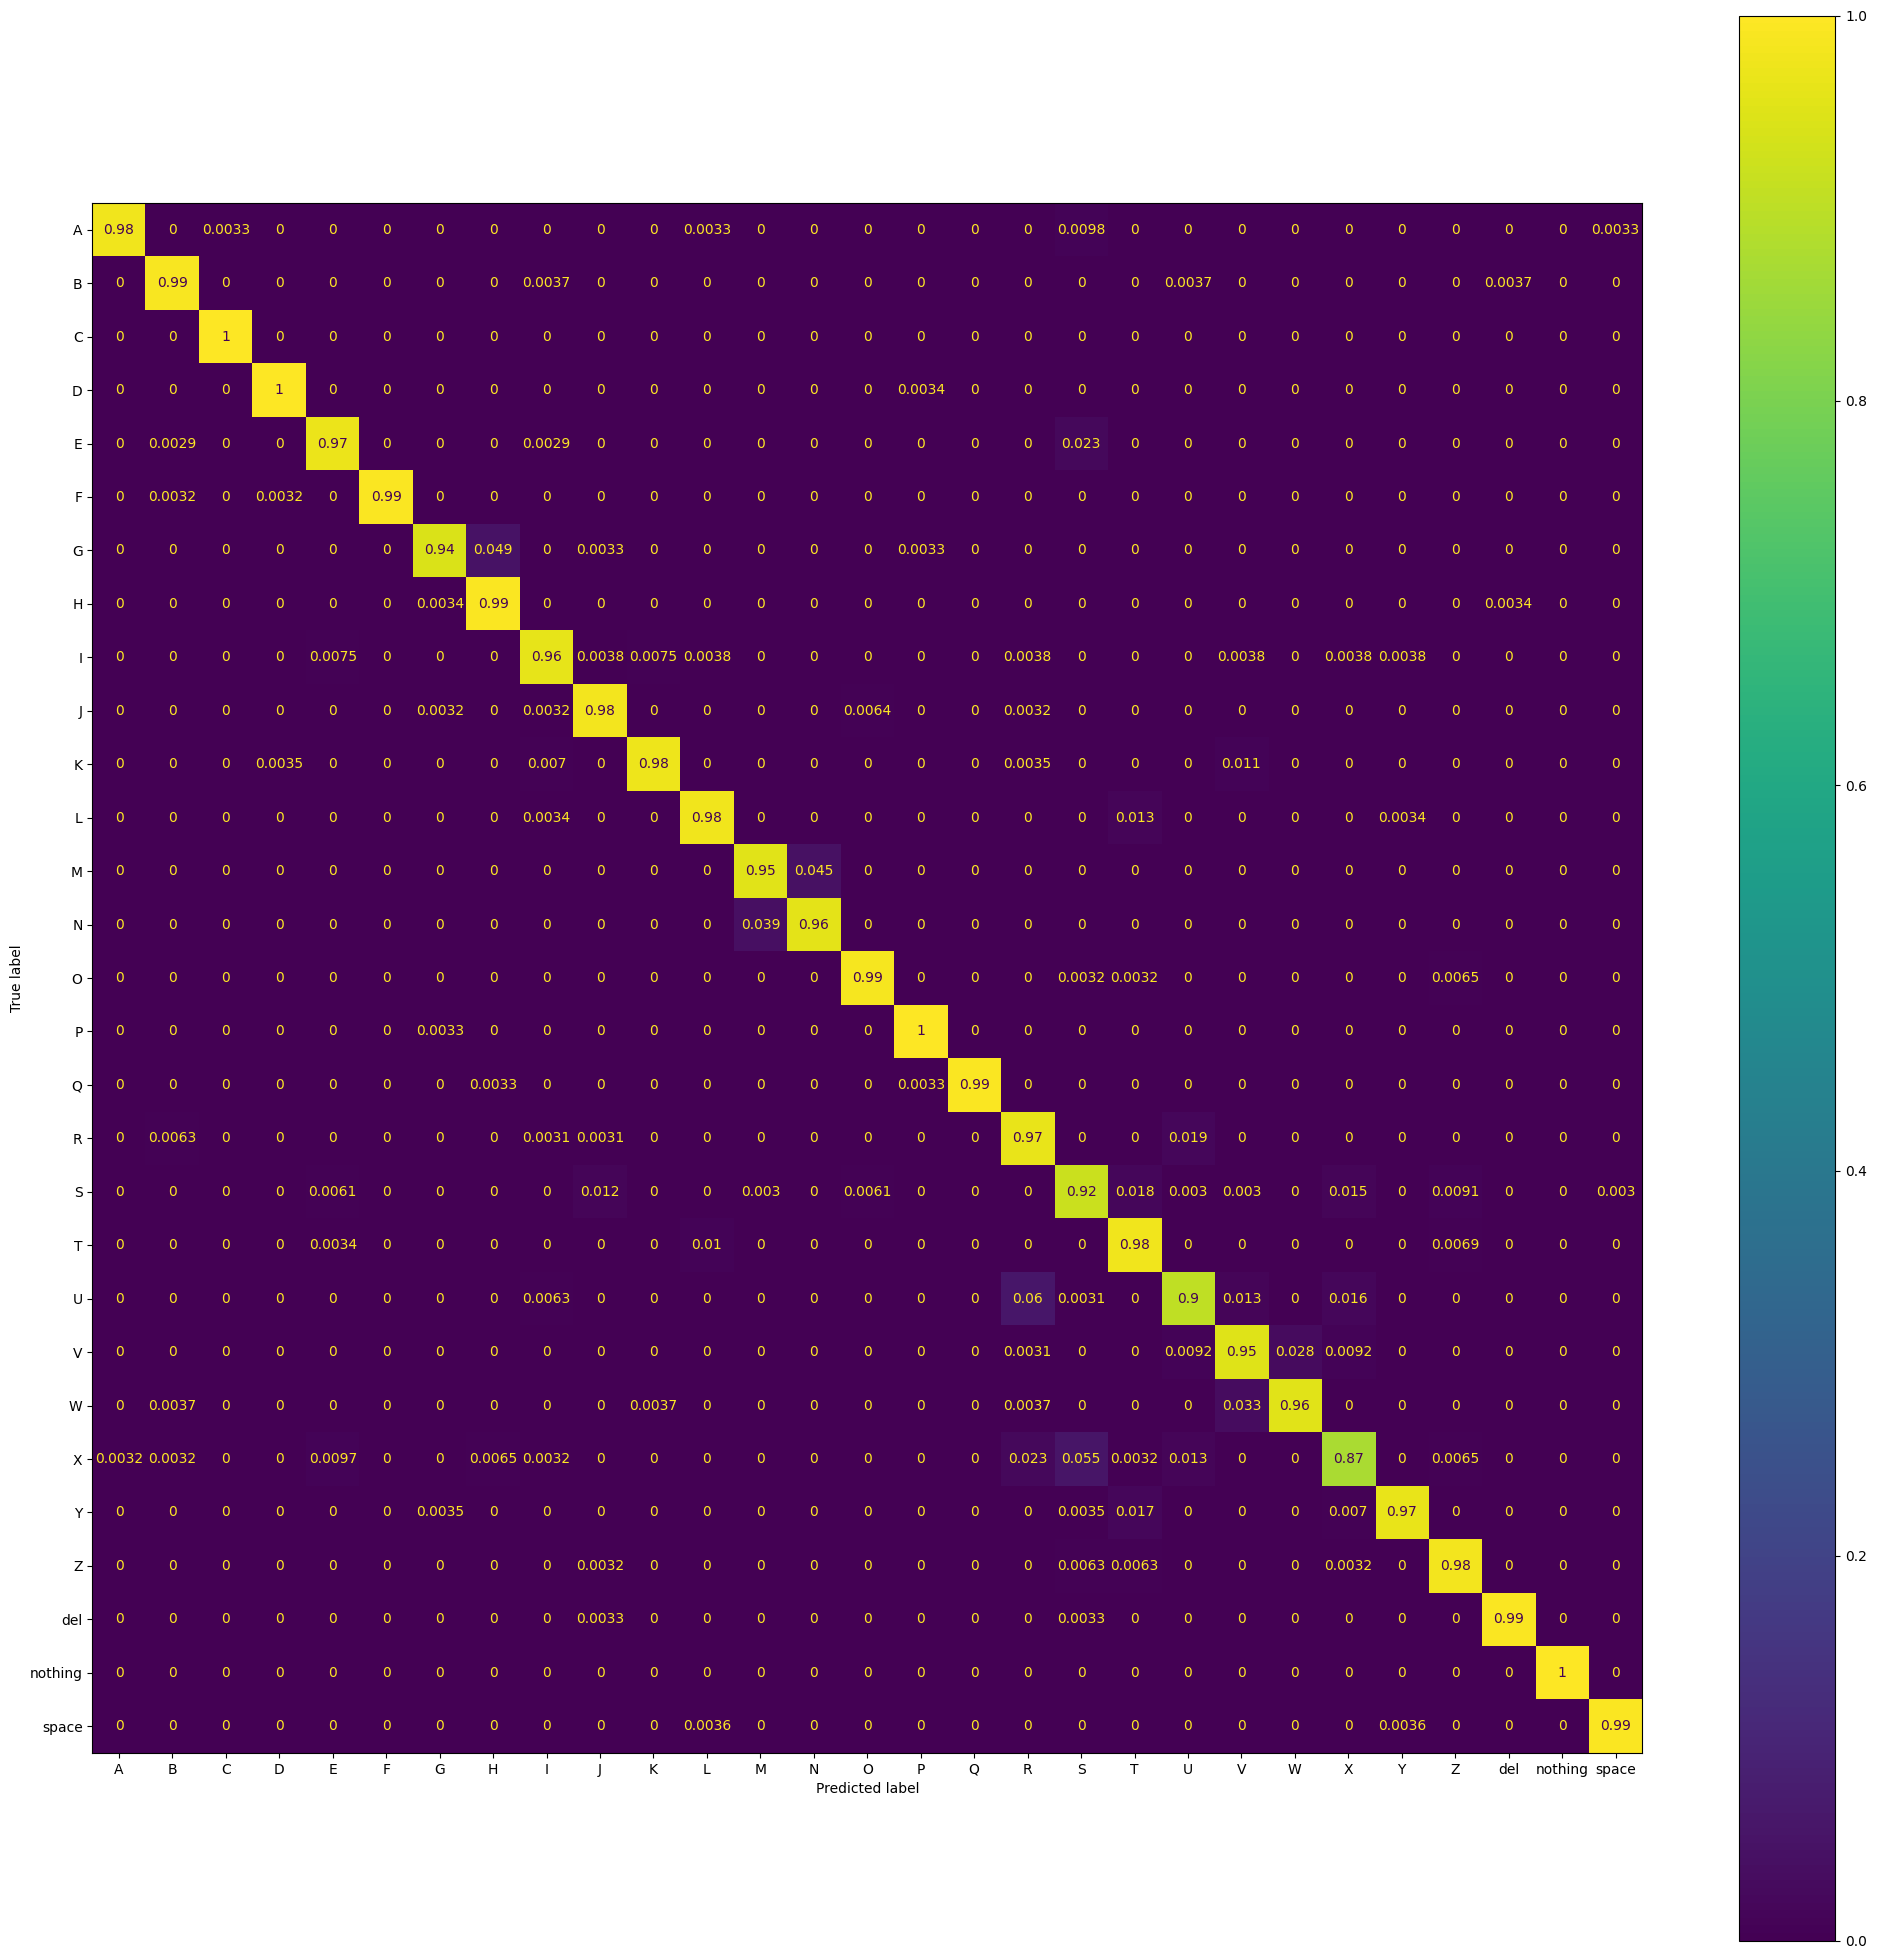

In [144]:
save_cfm_plot(model_name, results)

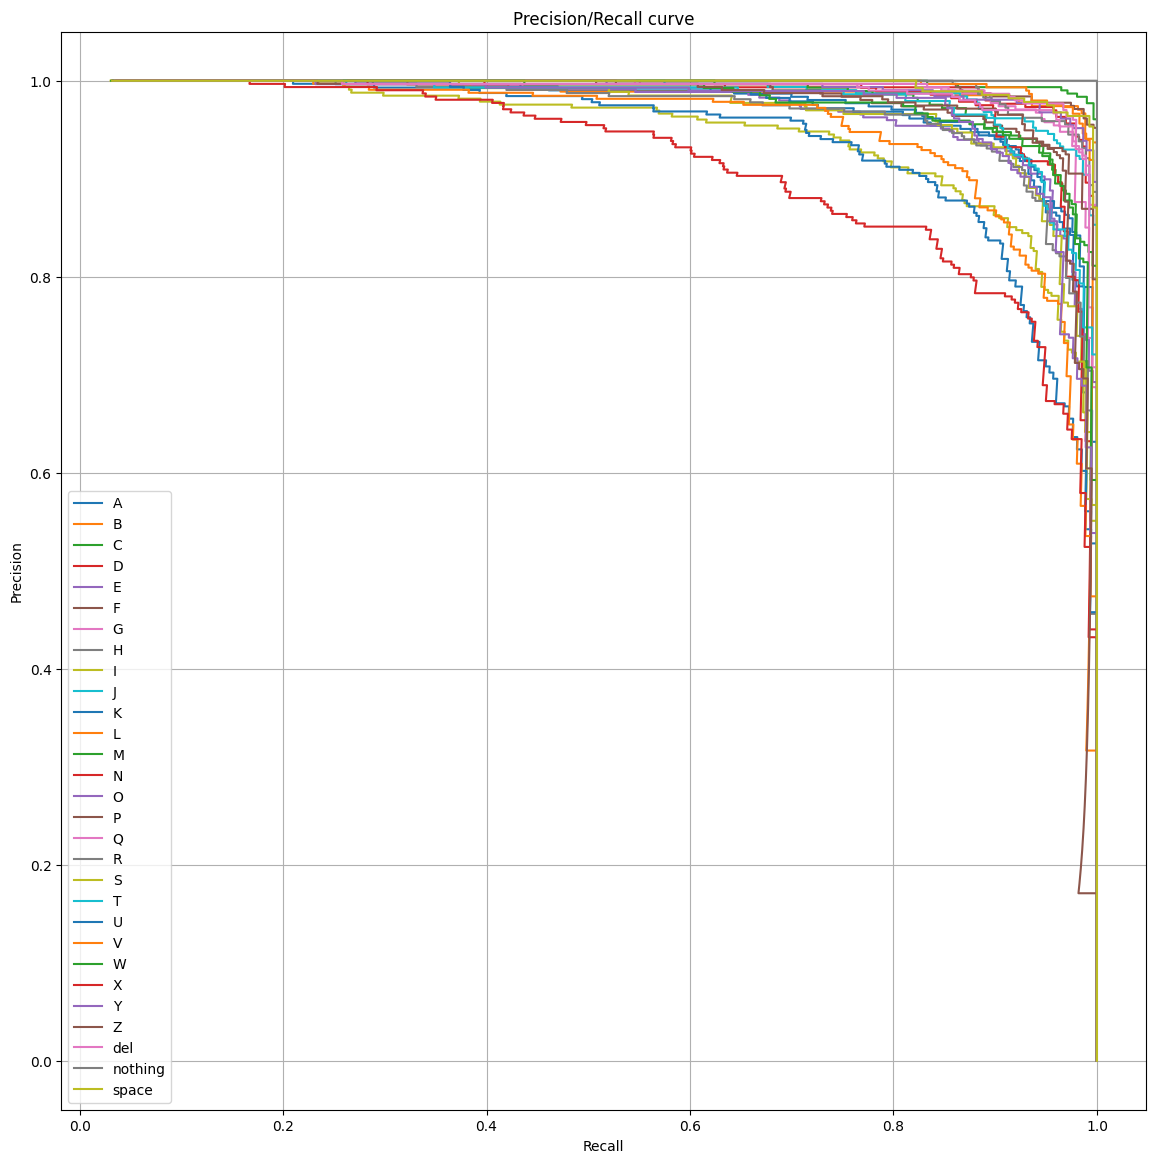

In [21]:
save_pr_curve_plot(model_name, results)

# Fine Tuning


### ResNeXt50 finetuning setup


In [25]:
## Setup Resnext50
model_name = "resnext_adam"
print(f"Model name: {model_name}")
model, model_fc = load_resnext50_model()
finetuneable_layers = [model.layer3, model.layer4]

## Setup layers for training
for param in model.parameters():
    param.requires_grad = False

# Open up fc layer for training
model.fc.requires_grad = True

# Open convulational layers for training
for layer in finetuneable_layers:
    for param in layer.parameters():
        param.requires_grad = True

save_model_name = "resnet_adam_finetune_augment"


norm_dataloaders, class_names, batch_size, dataset_sizes = gen_dataloaders(batch_size=64)

Model name: resnext_adam
Total number of trainable parameters: 23039325
Dataset sizes: {'train': 69600, 'val': 8700, 'test': 8700}
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


### Setup MobilenetV2


In [21]:
## Setup MobileNet
load_model_name = "mobilenet_adam"
print(f"Load model name: {load_model_name}")
model, model_fc = load_mobilenet_model()

## Setup layers for training
for param in model.parameters():
    param.requires_grad = True

save_model_name = "mobilenet_adam_finetune_erase_gauss_warmup"

# Load data
erase_gauss_dataloaders, class_names, batch_size, dataset_sizes = gen_dataloaders(
    normalize=True,
    batch_size=16,
    add_transforms=[
        transforms.RandomErasing(p=0.5, ratio=(0.5, 2), value=0, scale=(0.05, 0.1)),
        GaussNoise(sigma=0.01, p=0.5),
    ],
)

Load model name: mobilenet_adam


### Load best model params


In [22]:
model_path = f"{load_model_name}/best_model_params.pt"
result = model.load_state_dict(torch.load(model_path))

## Fine tuning / Training


In [23]:
from warmup_scheduler import GradualWarmupScheduler

## Set training mode
model.train()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_fc.parameters(), lr=0.6, weight_decay=1e-4)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler_stepLR = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
scheduler_warmup = GradualWarmupScheduler(
    optimizer, multiplier=1, total_epoch=5, after_scheduler=scheduler_stepLR
)


finetuned_model, history_ft = train_model(
    model,
    erase_gauss_dataloaders,
    criterion,
    optimizer,
    scheduler_warmup,
    num_epochs=100,
    save_dir=save_model_name,
)

Epoch 1/100
----------
Learning rate: [0.0]


train Loss: 0.7826 Acc: 0.7710


val Loss: 0.5816 Acc: 0.8343
Found new best accuracy! Saving best model to mobilenet_adam_finetune_erase_gauss_warmup/best_model_params.pt...

Epoch 2/100
----------
Learning rate: [0.12]


train Loss: 31.0650 Acc: 0.6154


val Loss: 14.9364 Acc: 0.7580

Epoch 3/100
----------
Learning rate: [0.24]


train Loss: 55.5657 Acc: 0.5935


val Loss: 43.7282 Acc: 0.6693

Epoch 4/100
----------
Learning rate: [0.36]


train Loss: 83.6776 Acc: 0.5663


val Loss: 51.8685 Acc: 0.6514

Epoch 5/100
----------
Learning rate: [0.48]


train Loss: 110.4203 Acc: 0.5431


val Loss: 75.3374 Acc: 0.6515

Epoch 6/100
----------
Learning rate: [0.6]


train Loss: 140.5268 Acc: 0.5226


val Loss: 84.0827 Acc: 0.6564

Epoch 7/100
----------
Learning rate: [0.6]


train Loss: 136.2312 Acc: 0.5279


val Loss: 173.9167 Acc: 0.5399

Epoch 8/100
----------
Learning rate: [0.54]


train Loss: 122.6755 Acc: 0.5390


val Loss: 73.5188 Acc: 0.6509

Epoch 9/100
----------
Learning rate: [0.48600000000000004]


train Loss: 111.5705 Acc: 0.5447


val Loss: 80.1668 Acc: 0.6277

Epoch 10/100
----------
Learning rate: [0.43740000000000007]


train Loss: 99.2073 Acc: 0.5564


val Loss: 67.6040 Acc: 0.6260

Epoch 11/100
----------
Learning rate: [0.39366000000000007]


train Loss: 89.3897 Acc: 0.5640


val Loss: 73.8847 Acc: 0.6179

Epoch 12/100
----------
Learning rate: [0.35429400000000005]


train Loss: 81.7588 Acc: 0.5714


val Loss: 57.5202 Acc: 0.6290

Epoch 13/100
----------
Learning rate: [0.31886460000000005]


train Loss: 72.7105 Acc: 0.5805


val Loss: 67.5357 Acc: 0.6387

Epoch 14/100
----------
Learning rate: [0.28697814000000005]


train Loss: 65.4610 Acc: 0.5885


val Loss: 53.2568 Acc: 0.6544

Epoch 15/100
----------
Learning rate: [0.25828032600000006]


train Loss: 58.4580 Acc: 0.5992


val Loss: 34.4184 Acc: 0.7163

Epoch 16/100
----------
Learning rate: [0.23245229340000007]


train Loss: 53.8301 Acc: 0.6034


val Loss: 31.2594 Acc: 0.7103

Epoch 17/100
----------
Learning rate: [0.20920706406000006]


train Loss: 47.9643 Acc: 0.6126


val Loss: 42.0396 Acc: 0.6410

Epoch 18/100
----------
Learning rate: [0.18828635765400006]


train Loss: 43.1130 Acc: 0.6184


val Loss: 28.0989 Acc: 0.7238

Epoch 19/100
----------
Learning rate: [0.16945772188860006]


train Loss: 39.2251 Acc: 0.6245


val Loss: 24.7622 Acc: 0.7178

Epoch 20/100
----------
Learning rate: [0.15251194969974005]


train Loss: 35.6063 Acc: 0.6330


val Loss: 26.7426 Acc: 0.7157

Epoch 21/100
----------
Learning rate: [0.13726075472976604]


train Loss: 31.5649 Acc: 0.6416


val Loss: 18.1543 Acc: 0.7545

Epoch 22/100
----------
Learning rate: [0.12353467925678943]


train Loss: 28.5070 Acc: 0.6511


val Loss: 10.5078 Acc: 0.8047

Epoch 23/100
----------
Learning rate: [0.11118121133111049]


train Loss: 25.4673 Acc: 0.6568


val Loss: 16.3143 Acc: 0.7370

Epoch 24/100
----------
Learning rate: [0.10006309019799944]


train Loss: 23.4226 Acc: 0.6597


val Loss: 15.2321 Acc: 0.7876

Epoch 25/100
----------
Learning rate: [0.0900567811781995]


train Loss: 21.0125 Acc: 0.6688


val Loss: 16.6627 Acc: 0.7346

Epoch 26/100
----------
Learning rate: [0.08105110306037955]


train Loss: 19.3006 Acc: 0.6737


val Loss: 12.6031 Acc: 0.7576

Epoch 27/100
----------
Learning rate: [0.07294599275434159]


train Loss: 17.1848 Acc: 0.6815


val Loss: 11.8804 Acc: 0.7480

Epoch 28/100
----------
Learning rate: [0.06565139347890743]


train Loss: 15.5538 Acc: 0.6855


val Loss: 11.0460 Acc: 0.7517

Epoch 29/100
----------
Learning rate: [0.05908625413101669]


train Loss: 14.2060 Acc: 0.6895


val Loss: 8.9094 Acc: 0.7743

Epoch 30/100
----------
Learning rate: [0.053177628717915024]


train Loss: 12.8807 Acc: 0.6965


val Loss: 9.4019 Acc: 0.7524

Epoch 31/100
----------
Learning rate: [0.04785986584612352]


train Loss: 11.6613 Acc: 0.7006


val Loss: 6.2466 Acc: 0.7986

Epoch 32/100
----------
Learning rate: [0.04307387926151117]


train Loss: 10.6390 Acc: 0.7052


val Loss: 5.9792 Acc: 0.8077

Epoch 33/100
----------
Learning rate: [0.03876649133536005]


train Loss: 9.6849 Acc: 0.7086


val Loss: 6.3867 Acc: 0.7878

Epoch 34/100
----------
Learning rate: [0.03488984220182405]


train Loss: 8.7352 Acc: 0.7139


val Loss: 3.9284 Acc: 0.8318

Epoch 35/100
----------
Learning rate: [0.03140085798164165]


train Loss: 7.9403 Acc: 0.7194


val Loss: 4.0728 Acc: 0.8277

Epoch 36/100
----------
Learning rate: [0.028260772183477483]


train Loss: 7.2528 Acc: 0.7252


val Loss: 4.7780 Acc: 0.7897

Epoch 37/100
----------
Learning rate: [0.025434694965129734]


train Loss: 6.5139 Acc: 0.7300


val Loss: 4.1791 Acc: 0.8151

Epoch 38/100
----------
Learning rate: [0.02289122546861676]


train Loss: 5.9945 Acc: 0.7326


val Loss: 3.0796 Acc: 0.8297

Epoch 39/100
----------
Learning rate: [0.020602102921755086]


train Loss: 5.3660 Acc: 0.7374


val Loss: 3.9035 Acc: 0.7908

Epoch 40/100
----------
Learning rate: [0.018541892629579577]


train Loss: 4.8446 Acc: 0.7441


val Loss: 2.6704 Acc: 0.8311

Epoch 41/100
----------
Learning rate: [0.01668770336662162]


train Loss: 4.4127 Acc: 0.7471


val Loss: 2.2672 Acc: 0.8409
Found new best accuracy! Saving best model to mobilenet_adam_finetune_erase_gauss_warmup/best_model_params.pt...

Epoch 42/100
----------
Learning rate: [0.015018933029959458]


train Loss: 3.9906 Acc: 0.7525


val Loss: 1.7328 Acc: 0.8540
Found new best accuracy! Saving best model to mobilenet_adam_finetune_erase_gauss_warmup/best_model_params.pt...

Epoch 43/100
----------
Learning rate: [0.013517039726963513]


train Loss: 3.6802 Acc: 0.7527


val Loss: 1.6135 Acc: 0.8594
Found new best accuracy! Saving best model to mobilenet_adam_finetune_erase_gauss_warmup/best_model_params.pt...

Epoch 44/100
----------
Learning rate: [0.012165335754267162]


train Loss: 3.3992 Acc: 0.7561


val Loss: 1.5220 Acc: 0.8525

Epoch 45/100
----------
Learning rate: [0.010948802178840446]


train Loss: 3.0805 Acc: 0.7617


val Loss: 1.6121 Acc: 0.8480

Epoch 46/100
----------
Learning rate: [0.009853921960956403]


train Loss: 2.8252 Acc: 0.7635


val Loss: 1.5911 Acc: 0.8411

Epoch 47/100
----------
Learning rate: [0.008868529764860763]


train Loss: 2.5229 Acc: 0.7697


val Loss: 1.4119 Acc: 0.8499

Epoch 48/100
----------
Learning rate: [0.007981676788374687]


train Loss: 2.3498 Acc: 0.7718


val Loss: 0.9286 Acc: 0.8749
Found new best accuracy! Saving best model to mobilenet_adam_finetune_erase_gauss_warmup/best_model_params.pt...

Epoch 49/100
----------
Learning rate: [0.007183509109537218]


train Loss: 2.1049 Acc: 0.7762


val Loss: 0.8351 Acc: 0.8811
Found new best accuracy! Saving best model to mobilenet_adam_finetune_erase_gauss_warmup/best_model_params.pt...

Epoch 50/100
----------
Learning rate: [0.006465158198583496]


train Loss: 1.9439 Acc: 0.7765


val Loss: 0.8987 Acc: 0.8675

Epoch 51/100
----------
Learning rate: [0.0058186423787251465]


train Loss: 1.7583 Acc: 0.7822


val Loss: 0.8619 Acc: 0.8659

Epoch 52/100
----------
Learning rate: [0.005236778140852632]


train Loss: 1.6295 Acc: 0.7830


val Loss: 0.7428 Acc: 0.8795

Epoch 53/100
----------
Learning rate: [0.004713100326767369]


train Loss: 1.5099 Acc: 0.7885


val Loss: 0.5245 Acc: 0.9014
Found new best accuracy! Saving best model to mobilenet_adam_finetune_erase_gauss_warmup/best_model_params.pt...

Epoch 54/100
----------
Learning rate: [0.004241790294090632]


train Loss: 1.3611 Acc: 0.7920


val Loss: 0.6729 Acc: 0.8817

Epoch 55/100
----------
Learning rate: [0.0038176112646815686]


train Loss: 1.2756 Acc: 0.7962


val Loss: 0.5088 Acc: 0.8962

Epoch 56/100
----------
Learning rate: [0.003435850138213412]


train Loss: 1.1732 Acc: 0.7977


val Loss: 0.4850 Acc: 0.8931

Epoch 57/100
----------
Learning rate: [0.0030922651243920707]


train Loss: 1.1077 Acc: 0.7992


val Loss: 0.5119 Acc: 0.8830

Epoch 58/100
----------
Learning rate: [0.0027830386119528636]


train Loss: 1.0093 Acc: 0.8048


val Loss: 0.4031 Acc: 0.9021
Found new best accuracy! Saving best model to mobilenet_adam_finetune_erase_gauss_warmup/best_model_params.pt...

Epoch 59/100
----------
Learning rate: [0.0025047347507575774]


train Loss: 0.9483 Acc: 0.8061


val Loss: 0.4019 Acc: 0.9002

Epoch 60/100
----------
Learning rate: [0.00225426127568182]


train Loss: 0.8664 Acc: 0.8121


val Loss: 0.3788 Acc: 0.8983

Epoch 61/100
----------
Learning rate: [0.0020288351481136378]


train Loss: 0.8394 Acc: 0.8119


val Loss: 0.3756 Acc: 0.8931

Epoch 62/100
----------
Learning rate: [0.001825951633302274]


train Loss: 0.7901 Acc: 0.8173


val Loss: 0.3073 Acc: 0.9110
Found new best accuracy! Saving best model to mobilenet_adam_finetune_erase_gauss_warmup/best_model_params.pt...

Epoch 63/100
----------
Learning rate: [0.0016433564699720466]


train Loss: 0.7360 Acc: 0.8200


val Loss: 0.3051 Acc: 0.9087

Epoch 64/100
----------
Learning rate: [0.001479020822974842]


train Loss: 0.7118 Acc: 0.8206


val Loss: 0.3361 Acc: 0.9018

Epoch 65/100
----------
Learning rate: [0.0013311187406773578]


train Loss: 0.6659 Acc: 0.8260


val Loss: 0.2543 Acc: 0.9206
Found new best accuracy! Saving best model to mobilenet_adam_finetune_erase_gauss_warmup/best_model_params.pt...

Epoch 66/100
----------
Learning rate: [0.0011980068666096221]


train Loss: 0.6453 Acc: 0.8274


val Loss: 0.2515 Acc: 0.9190

Epoch 67/100
----------
Learning rate: [0.0010782061799486599]


train Loss: 0.6145 Acc: 0.8303


val Loss: 0.3398 Acc: 0.8987

Epoch 68/100
----------
Learning rate: [0.0009703855619537939]


train Loss: 0.5914 Acc: 0.8328


val Loss: 0.2857 Acc: 0.9108

Epoch 69/100
----------
Learning rate: [0.0008733470057584145]


train Loss: 0.5740 Acc: 0.8352


val Loss: 0.2583 Acc: 0.9178

Epoch 70/100
----------
Learning rate: [0.000786012305182573]


train Loss: 0.5563 Acc: 0.8365


val Loss: 0.2458 Acc: 0.9182

Epoch 71/100
----------
Learning rate: [0.0007074110746643158]


train Loss: 0.5469 Acc: 0.8392


val Loss: 0.2200 Acc: 0.9306
Found new best accuracy! Saving best model to mobilenet_adam_finetune_erase_gauss_warmup/best_model_params.pt...

Epoch 72/100
----------
Learning rate: [0.0006366699671978843]


train Loss: 0.5268 Acc: 0.8435


val Loss: 0.2299 Acc: 0.9241

Epoch 73/100
----------
Learning rate: [0.0005730029704780959]


train Loss: 0.5192 Acc: 0.8433


val Loss: 0.2440 Acc: 0.9182

Epoch 74/100
----------
Learning rate: [0.0005157026734302863]


train Loss: 0.5062 Acc: 0.8459


val Loss: 0.2150 Acc: 0.9317
Found new best accuracy! Saving best model to mobilenet_adam_finetune_erase_gauss_warmup/best_model_params.pt...

Epoch 75/100
----------
Learning rate: [0.0004641324060872577]


train Loss: 0.4964 Acc: 0.8475


val Loss: 0.2293 Acc: 0.9251

Epoch 76/100
----------
Learning rate: [0.00041771916547853196]


train Loss: 0.4857 Acc: 0.8485


val Loss: 0.2070 Acc: 0.9328
Found new best accuracy! Saving best model to mobilenet_adam_finetune_erase_gauss_warmup/best_model_params.pt...

Epoch 77/100
----------
Learning rate: [0.00037594724893067876]


train Loss: 0.4819 Acc: 0.8491


val Loss: 0.2306 Acc: 0.9252

Epoch 78/100
----------
Learning rate: [0.0003383525240376109]


train Loss: 0.4811 Acc: 0.8493


val Loss: 0.1998 Acc: 0.9332
Found new best accuracy! Saving best model to mobilenet_adam_finetune_erase_gauss_warmup/best_model_params.pt...

Epoch 79/100
----------
Learning rate: [0.00030451727163384977]


train Loss: 0.4689 Acc: 0.8546


val Loss: 0.2185 Acc: 0.9317

Epoch 80/100
----------
Learning rate: [0.0002740655444704648]


train Loss: 0.4681 Acc: 0.8524


val Loss: 0.2235 Acc: 0.9278

Epoch 81/100
----------
Learning rate: [0.0002466589900234183]


train Loss: 0.4587 Acc: 0.8547


val Loss: 0.2303 Acc: 0.9279

Epoch 82/100
----------
Learning rate: [0.00022199309102107647]


train Loss: 0.4597 Acc: 0.8554


val Loss: 0.2097 Acc: 0.9361
Found new best accuracy! Saving best model to mobilenet_adam_finetune_erase_gauss_warmup/best_model_params.pt...

Epoch 83/100
----------
Learning rate: [0.00019979378191896884]


train Loss: 0.4496 Acc: 0.8573


val Loss: 0.2102 Acc: 0.9309

Epoch 84/100
----------
Learning rate: [0.00017981440372707197]


train Loss: 0.4459 Acc: 0.8577


val Loss: 0.2122 Acc: 0.9324

Epoch 85/100
----------
Learning rate: [0.00016183296335436478]


train Loss: 0.4463 Acc: 0.8574


val Loss: 0.2063 Acc: 0.9372
Found new best accuracy! Saving best model to mobilenet_adam_finetune_erase_gauss_warmup/best_model_params.pt...

Epoch 86/100
----------
Learning rate: [0.0001456496670189283]


train Loss: 0.4449 Acc: 0.8589


val Loss: 0.2007 Acc: 0.9391
Found new best accuracy! Saving best model to mobilenet_adam_finetune_erase_gauss_warmup/best_model_params.pt...

Epoch 87/100
----------
Learning rate: [0.00013108470031703546]


train Loss: 0.4423 Acc: 0.8601


val Loss: 0.2036 Acc: 0.9359

Epoch 88/100
----------
Learning rate: [0.00011797623028533192]


train Loss: 0.4410 Acc: 0.8590


val Loss: 0.1987 Acc: 0.9351

Epoch 89/100
----------
Learning rate: [0.00010617860725679873]


train Loss: 0.4401 Acc: 0.8597


val Loss: 0.2220 Acc: 0.9305

Epoch 90/100
----------
Learning rate: [9.556074653111886e-05]


train Loss: 0.4391 Acc: 0.8610


val Loss: 0.2051 Acc: 0.9330

Epoch 91/100
----------
Learning rate: [8.600467187800698e-05]


train Loss: 0.4395 Acc: 0.8609


val Loss: 0.1982 Acc: 0.9410
Found new best accuracy! Saving best model to mobilenet_adam_finetune_erase_gauss_warmup/best_model_params.pt...

Epoch 92/100
----------
Learning rate: [7.740420469020628e-05]


train Loss: 0.4388 Acc: 0.8602


val Loss: 0.2019 Acc: 0.9391

Epoch 93/100
----------
Learning rate: [6.966378422118566e-05]


train Loss: 0.4344 Acc: 0.8609


val Loss: 0.2026 Acc: 0.9384

Epoch 94/100
----------
Learning rate: [6.269740579906709e-05]


train Loss: 0.4322 Acc: 0.8632


val Loss: 0.1951 Acc: 0.9411
Found new best accuracy! Saving best model to mobilenet_adam_finetune_erase_gauss_warmup/best_model_params.pt...

Epoch 95/100
----------
Learning rate: [5.642766521916038e-05]


train Loss: 0.4368 Acc: 0.8614


val Loss: 0.2086 Acc: 0.9347

Epoch 96/100
----------
Learning rate: [5.078489869724434e-05]


train Loss: 0.4309 Acc: 0.8616


val Loss: 0.2074 Acc: 0.9369

Epoch 97/100
----------
Learning rate: [4.570640882751991e-05]


train Loss: 0.4312 Acc: 0.8621


val Loss: 0.2100 Acc: 0.9346

Epoch 98/100
----------
Learning rate: [4.113576794476792e-05]


train Loss: 0.4356 Acc: 0.8621


val Loss: 0.2086 Acc: 0.9336

Epoch 99/100
----------
Learning rate: [3.702219115029113e-05]


train Loss: 0.4324 Acc: 0.8614


val Loss: 0.1985 Acc: 0.9395

Epoch 100/100
----------
Learning rate: [3.331997203526202e-05]


train Loss: 0.4302 Acc: 0.8625


val Loss: 0.1956 Acc: 0.9414
Found new best accuracy! Saving best model to mobilenet_adam_finetune_erase_gauss_warmup/best_model_params.pt...

Training complete in 720m 48s
Best accuracy: 0.9413793103448276


### LR finder

In [ ]:
!pip install -q torch-lr-finder -v --global-option="apex"

In [ ]:
from torch_lr_finder import LRFinder
torch.cuda.empty_cache()
dataloaders, class_names, batch_size, dataset_sizes = gen_dataloaders(batch_size=16)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

# Receptive field analysis

Rasmus <3

Check whether neurons are blank to argue whether or not ResNeXt is too overkill. Can argue for modifying ResNeXt or choosing a more light weight model.


# Plot loss over epochs

Mamus <3

Gather information for learning rate in fine tuning.
See Howard


In [257]:
def show_history(histories, model_names):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

    flatten = lambda l: [item for sublist in l for item in sublist]

    legends = flatten(
        [[f"{m} Train", f"{m} Validation"] for m in model_names],
    )

    colors = ["tab:orange", "tab:blue", "tab:green", "tab:red"]

    # summarize history for accuracy
    for i, history in enumerate(histories):
        ax1.plot(
            history["accuracy"],
            color=colors[i],
        )
        ax1.plot(
            history["val_accuracy"],
            linestyle="dotted",
            color=colors[i],
        )
    ax1.set_title("Accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.set_xlabel("Epoch")
    ax1.legend(
        legends,
        loc="lower right",
    )
    # summarize history for loss
    for i, history in enumerate(histories):
        ax2.plot(
            history["loss"],
            color=colors[i],
        )
        ax2.plot(
            history["val_loss"],
            linestyle="dotted",
            color=colors[i],
        )
    ax2.set_title("Loss")
    ax2.set_ylabel("Loss")
    ax2.set_xlabel("Epoch")
    ax2.legend(
        legends,
        loc="upper right",
    )

    # summarize history for lr
    for i, history in enumerate(histories):
        if ("lr" in history) and len(history["lr"]) > 0:
            ax3.plot(history["lr"], color=colors[i])
    ax3.set_title("Learning rate")
    ax3.set_ylabel("LR")
    ax3.set_xlabel("Epoch")

    fig.show()

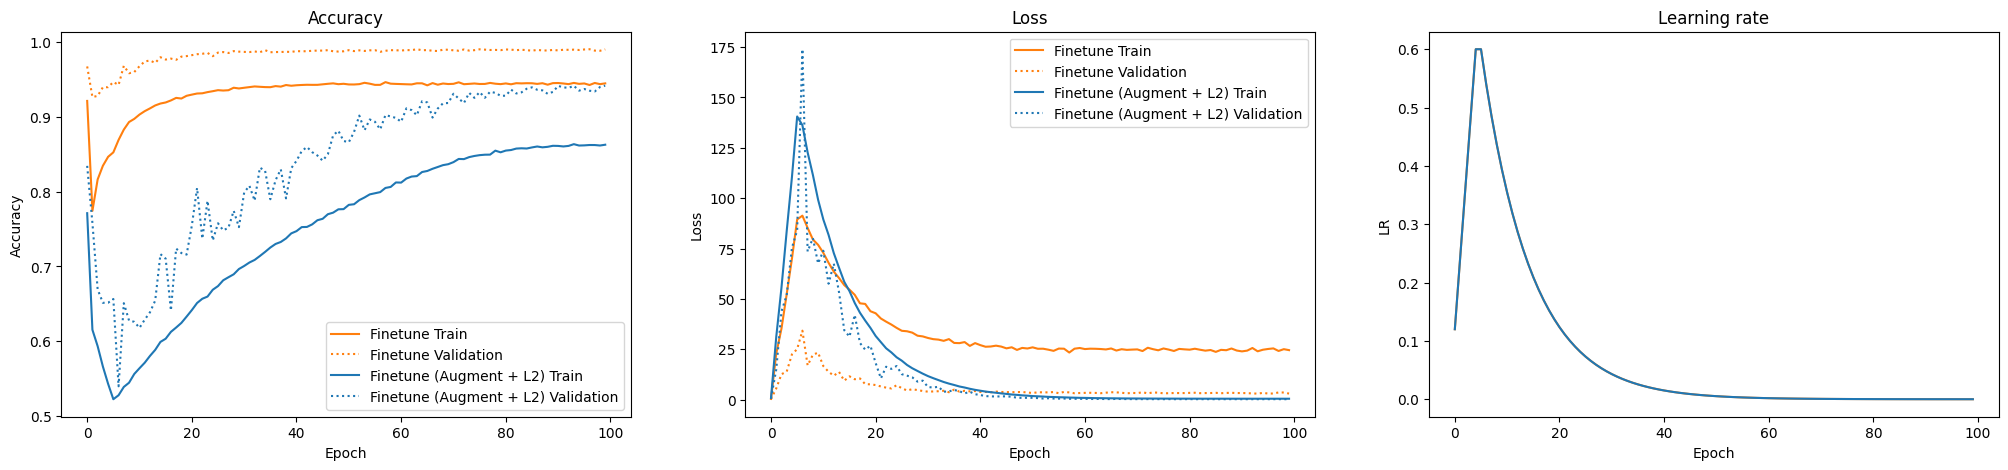

In [260]:
# Load history file
model_names = [
    "Finetune",
    "Finetune (Augment + L2)",
]
histories = [
    torch.load(f"{model_name}/model_history.pt")
    for model_name in ["mobilenet_adam_finetune_raw", "mobilenet_adam_finetune_erase_gauss_warmup"]
]

show_history(histories, model_names)

# Class Activation Maps


In [147]:
def get_sample_of_class(dataloader, class_name: str, image_index=0):
    class_index = class_names.index(class_name.upper())
    i = 0
    for image, label in dataloader.dataset:
        if label == class_index:
            if i == image_index:
                return torch.unsqueeze(image, dim=0), label
            i += 1

## Heat maps

In [11]:
!pip install -q torchcam

In [255]:
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from torchvision.models import MobileNetV2


def plot_image_heatmap(
    figure: plt.figure,
    model: MobileNetV2,
    norm_image,
    original_image,
    get_model_features,
):
    layer = get_model_features(model)
    cam_extractor = SmoothGradCAMpp(model, layer)

    model.eval()

    # Preprocess your data and feed it to the model
    out = model(norm_image.to(device))
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

    result = overlay_mask(
        to_pil_image(original_image.squeeze(0)),
        to_pil_image(activation_map[0].squeeze(0), mode="F"),
        alpha=0.5,
    )

    figure.imshow(result)


# Take a list of model names and create a heatmap for each model
def models_heatmap(
    title,
    model_names,
    model_labels,
    class_names: list[str],
    get_model_features,
    image_index=0,
):
    fig, axs = plt.subplots(
        len(class_names),
        len(model_names) + 1,
        constrained_layout=True,
        sharey=True,
        tight_layout=True,
        figsize=(10, 10),
    )

    # fig.suptitle(title)

    for ax in axs.flat:
        ax.set(xticks=[], yticks=[])

    for row, class_name in enumerate(class_names):
        norm_dataloaders, class_names, batch_size, dataset_sizes, _ = gen_dataloaders()
        unnorm_dataloaders, class_names, batch_size, dataset_sizes, _ = gen_dataloaders(
            normalize=False
        )
        image, label = get_sample_of_class(
            norm_dataloaders["val"], class_name, image_index
        )
        original_image, label = get_sample_of_class(
            unnorm_dataloaders["val"], class_name, image_index
        )

        axs[row, 0].set_ylabel(class_name, rotation="horizontal", ha="right", labelpad=15)
        axs[row, 0].imshow(to_pil_image(original_image.squeeze(0)))

        for col, model_name in enumerate(model_names):
            model_path = f"{model_name}/best_model_params.pt"
            model.load_state_dict(torch.load(model_path))

            plot_image_heatmap(
                axs[row, col + 1],
                model,
                image,
                original_image,
                get_model_features,
            )

            if (row == 0):
                axs[row, col + 1].set_title(model_labels[col])

    fig.show()
    return fig

### Use own dataset to generate heat maps

In [287]:
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image


# Take a list of model names and create a heatmap for each model
def models_heatmap_own(
    title,
    model_names,
    model_labels,
    class_names: list[str],
    get_model_features,
    image_index=0,
):
    fig, axs = plt.subplots(
        len(class_names),
        len(model_names) + 1,
        constrained_layout=True,
        sharey=True,
        tight_layout=True,
        figsize=(10, 10),
    )

    # fig.suptitle(title)

    for ax in axs.flat:
        ax.set(xticks=[], yticks=[])

    for row, class_name in enumerate(class_names):
        (
            norm_dataloaders,
            _class_names,
            batch_size,
            dataset_sizes,
            test_data_loader,
        ) = gen_dataloaders()
        (
            unnorm_dataloaders,
            _class_names,
            batch_size,
            dataset_sizes,
            unormtest_data_loader,
        ) = gen_dataloaders(normalize=False)
        image, label = get_sample_of_class(test_data_loader, class_name, image_index)
        original_image, label = get_sample_of_class(
            unormtest_data_loader, class_name, image_index
        )

        axs[row, 0].set_ylabel(
            class_name, rotation="horizontal", ha="right", labelpad=15
        )
        axs[row, 0].imshow(to_pil_image(original_image.squeeze(0)))

        for col, model_name in enumerate(model_names):
            model_path = f"{model_name}/best_model_params.pt"
            result = model.load_state_dict(torch.load(model_path))

            layer = get_model_features(model)
            cam_extractor = SmoothGradCAMpp(model, layer)

            model.eval()

            # Preprocess your data and feed it to the model
            out = model(image.to(device))
            # Print prediction of the model
            probabilities = torch.nn.functional.softmax(out, dim=1).detach()
            _, top1_catid = torch.topk(probabilities, 1)
            # Retrieve the CAM by passing the class index and the model output
            activation_map = cam_extractor(_class_names.index(class_name))

            result = overlay_mask(
                to_pil_image(original_image.squeeze(0)),
                to_pil_image(activation_map[0].squeeze(0), mode="F"),
                alpha=0.5,
            )

            axs[row, col + 1].set_xlabel(
                f"Prediction: {_class_names[top1_catid[0].item()]}"
            )
            if (row == 0):
                axs[row, col + 1].set_title(model_labels[col])
            axs[row, col + 1].imshow(result)

    fig.show()

### ResNeXt50

In [16]:
from torchvision.models import ResNet
import random

# Heat maps for resnext50
model, model_fc = load_resnext50_model()

for p in model.layer3.parameters():
    p.requires_grad = True

def get_model_features(model: ResNet):
    return model.layer4[-1]

model_names = ["resnext_adam_finetune"]
random_index = random.randint(0, 10)
models_heatmap("resnext", model_names, ["initial"], ["S", "Y"], get_model_features, 0)

NameError: name 'load_resnext50_model' is not defined

### ResNeXt50 own data

In [ ]:
from torchvision.models import ResNet
import random

# Heat maps for resnext50
model, model_fc = load_resnext50_model()

for p in model.layer3.parameters():
    p.requires_grad = True

def get_model_features(model: ResNet):
    return model.layer4[-1]

model_names = ["resnext_adam_finetune"]
random_index = random.randint(0, 10)
models_heatmap_own("resnext", model_names, ["initial"], ["S", "Y"], get_model_features, 0)

### MobileNetV2

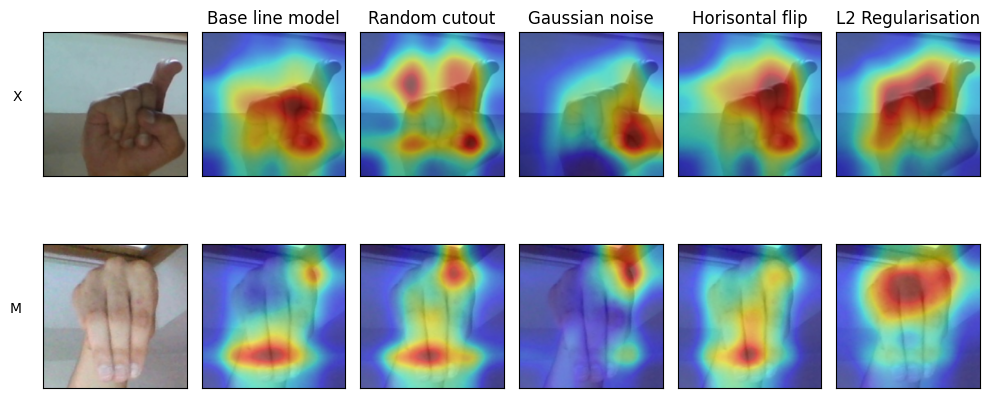

In [256]:
from torchvision.models import MobileNetV2
import random
# Heat maps for mobilenet

model, model_fc = load_mobilenet_model()


def get_model_features(model: MobileNetV2):
    return model.features[18]


model_names = [
    "mobilenet_adam",
    "mobilenet_adam_finetune_augment",
    "mobilenet_adam_finetune_gauss_noise",
    "mobilenet_adam_finetune_flip",
    "mobilenet_adam_finetune_regularisation_e4",
]

model_labels = [
    "Base line model",
    "Random cutout",
    "Gaussian noise",
    "Horisontal flip",
    "L2 Regularisation",
]

random_index = random.randint(0, 10)
models_heatmap(
    title="MobileNetV2",
    model_names = model_names,
    model_labels = model_labels,
    class_names=["X", "M"],
    get_model_features = get_model_features
).savefig(f"heatmap.svg", dpi=300, bbox_inches="tight")

### MobileNetV2 own data

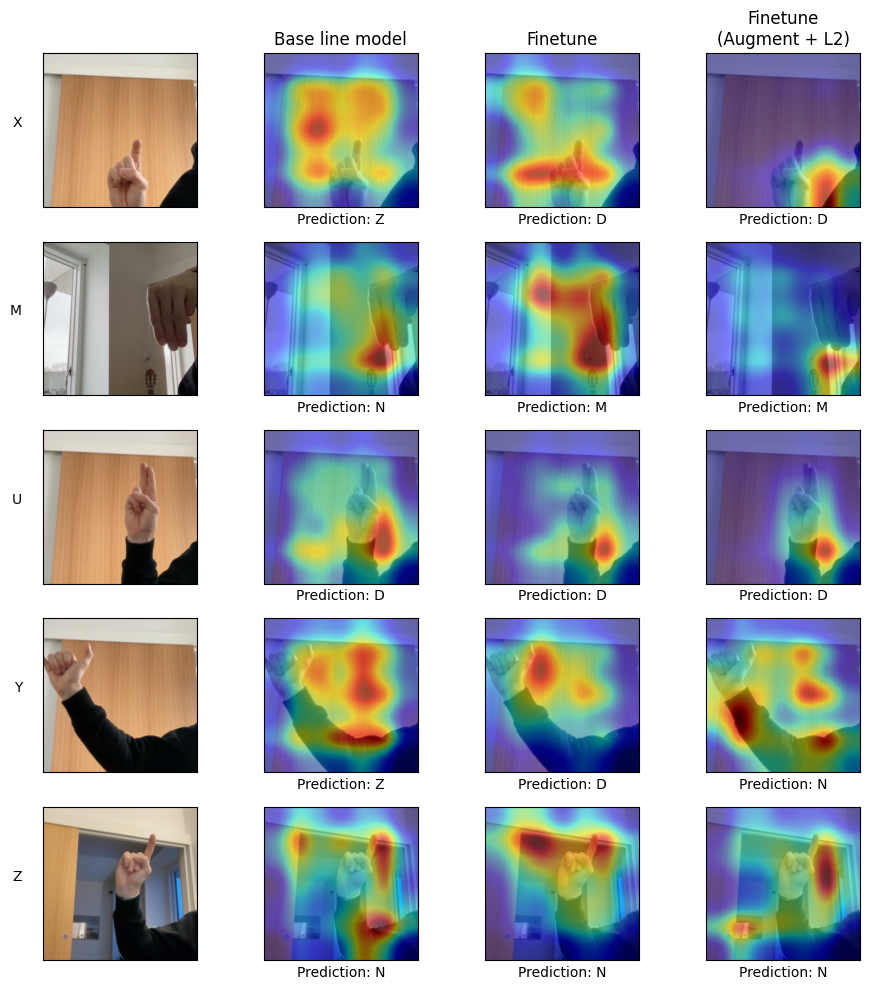

In [293]:
from torchvision.models import MobileNetV2
import random
# Heat maps for mobilenet

model, model_fc = load_mobilenet_model()

def get_model_features(model: MobileNetV2):
    return model.features[18]

model_names = [
    "mobilenet_adam",
    "mobilenet_adam_finetune_raw",
    "mobilenet_adam_finetune_erase_gauss_warmup"
]

model_labels = [
    "Base line model",
    "Finetune",
    "Finetune\n(Augment + L2)"
]

random_index = random.randint(0, 10)
models_heatmap_own(
    "MobileNetV2",
    model_names,
    model_labels,
    ["X", "M", "U", "Y", "Z"],
    get_model_features,
    0,
)

## Guided Backpropagation

In [20]:
from torchvision.models import MobileNetV2
import numpy as np


def relu_hook_function(module, grad_in, grad_out):
    if isinstance(module, torch.nn.ReLU):
        return (torch.clamp(grad_in[0], min=0.0),)


def set_model_backward_hook(model: MobileNetV2):
    for i, module in enumerate(model.modules()):
        if isinstance(module, torch.nn.ReLU):
            print(model.named_modules())
            module.register_backward_hook(relu_hook_function)


def prep_output(img_tensor):
    invTrans = torchvision.transforms.Compose(
        [
            torchvision.transforms.Normalize(
                mean=[0.0, 0.0, 0.0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
            ),
            torchvision.transforms.Normalize(
                mean=[-0.485, -0.456, -0.406], std=[1.0, 1.0, 1.0]
            ),
        ]
    )
    out = invTrans(img_tensor)[0]
    out = out.detach().numpy().transpose(1, 2, 0)

    return out


def norm_flat_image(img):
    grads_norm = prep_output(img)
    grads_norm = grads_norm[:, :, 0] + grads_norm[:, :, 1] + grads_norm[:, :, 2]

    grads_norm = (grads_norm - np.min(grads_norm)) / (
        np.max(grads_norm) - np.min(grads_norm)
    )
    return grads_norm


def get_guided_backpropagation_grads(class_name, image, model: MobileNetV2):
    model.eval()
    image.requires_grad = True
    output = model(image.to(device))
    output[0, class_names.index(class_name)].backward()

    return image.grad

In [153]:
def plot_guided_backprop(
    model, norm_image, original_image, class_name, figure: plt.Figure
):
    set_model_backward_hook(model)
    image_grads = get_guided_backpropagation_grads(class_name, norm_image, model)

    mix_val = 2

    figure.imshow(
        norm_flat_image(image_grads) * mix_val
        + norm_flat_image(original_image) / mix_val,
        # vmin=0.3,
        # vmax=0.7,
        cmap="gray",
    )

### All activation maps for a letter


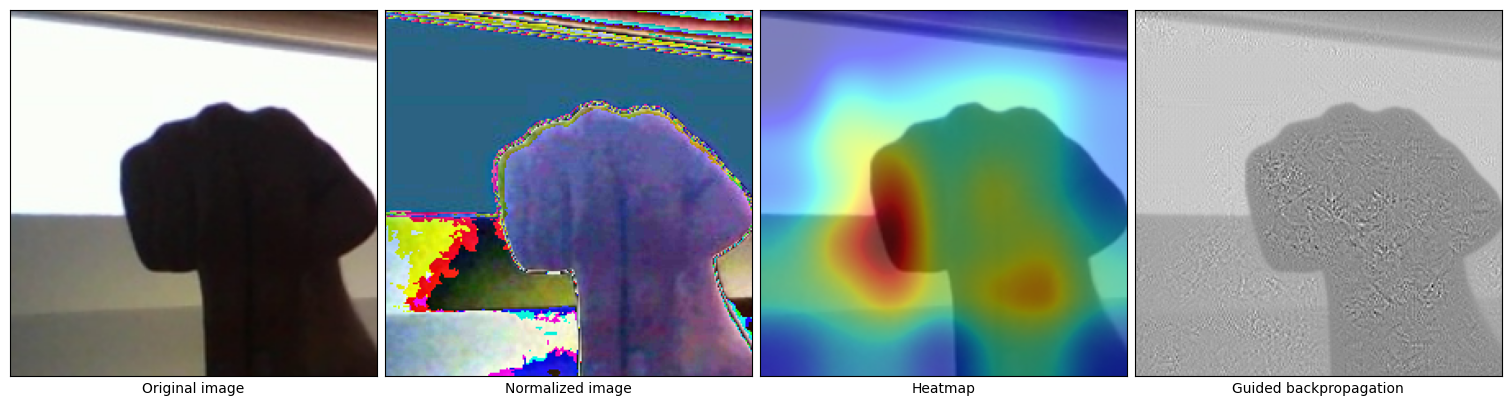

In [177]:
import random

class_name = "N"
image_index = random.randint(0, 10)
model_name = "mobilenet_adam"

model, model_fc = load_mobilenet_model()
model.load_state_dict(torch.load(f"{model_name}/best_model_params.pt"))


def get_model_features(model: MobileNetV2):
    return model.features[18]


figure, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(15, 4.5))
for ax in axs.flat:
    ax.set(xticks=[], yticks=[])
# figure.suptitle(f'Class activation maps for "{class_name}"')

norm_dataloaders, class_names, batch_size, dataset_sizes, _ = gen_dataloaders()
unnorm_dataloaders, class_names, batch_size, dataset_sizes, _ = gen_dataloaders(
    normalize=False
)

norm_image, label = get_sample_of_class(
    norm_dataloaders["test"], class_name, image_index
)
original_image, label = get_sample_of_class(
    unnorm_dataloaders["test"], class_name, image_index
)

# Plot original image
axs[0].set_xlabel("Original image")
axs[0].imshow(to_pil_image(original_image.squeeze(0)))

# Plot normalized image
axs[1].set_xlabel("Normalized image")
axs[1].imshow(to_pil_image(norm_image.squeeze(0)))

# Plot heatmap
plot_image_heatmap(
    axs[2],
    model,
    norm_image,
    original_image,
    get_model_features,
)
axs[2].set_xlabel("Heatmap")

# Plot guided backpropagation
plot_guided_backprop(model, norm_image, original_image, class_name, axs[3])
axs[3].set_xlabel("Guided backpropagation")

figure.show()

## Data augmentation

Use albumentation to augment data


In [ ]:
!pip install -U albumentations

torch.Size([3, 224, 224])


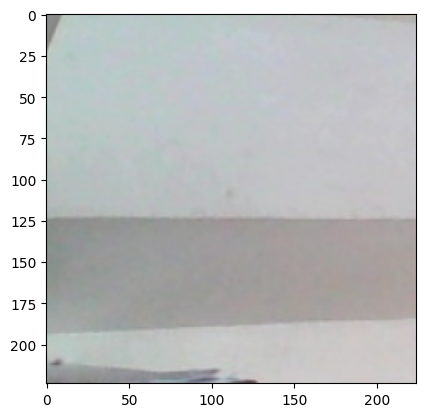

In [54]:
# Declare an augmentation pipeline

norm_dataloaders, class_names, batch_size, dataset_sizes = gen_dataloaders(False, [GaussNoise(0.01, 0.5)])
image = norm_dataloaders["train"].dataset[10][0]
print(image.shape)

# Display an image
imshow(image)

# Plots

## Data set showcase

['./asl_alphabet_train/asl_alphabet_train/A/A2.jpg', './asl_alphabet_train/asl_alphabet_train/B/B2.jpg', './asl_alphabet_train/asl_alphabet_train/C/C2.jpg', './asl_alphabet_train/asl_alphabet_train/D/D2.jpg', './asl_alphabet_train/asl_alphabet_train/E/E2.jpg', './asl_alphabet_train/asl_alphabet_train/F/F2.jpg', './asl_alphabet_train/asl_alphabet_train/G/G2.jpg', './asl_alphabet_train/asl_alphabet_train/H/H2.jpg', './asl_alphabet_train/asl_alphabet_train/I/I2.jpg', './asl_alphabet_train/asl_alphabet_train/J/J2.jpg', './asl_alphabet_train/asl_alphabet_train/K/K2.jpg', './asl_alphabet_train/asl_alphabet_train/L/L2.jpg', './asl_alphabet_train/asl_alphabet_train/M/M2.jpg', './asl_alphabet_train/asl_alphabet_train/N/N2.jpg', './asl_alphabet_train/asl_alphabet_train/O/O2.jpg', './asl_alphabet_train/asl_alphabet_train/P/P2.jpg', './asl_alphabet_train/asl_alphabet_train/Q/Q2.jpg', './asl_alphabet_train/asl_alphabet_train/R/R2.jpg', './asl_alphabet_train/asl_alphabet_train/S/S2.jpg', './asl_alph

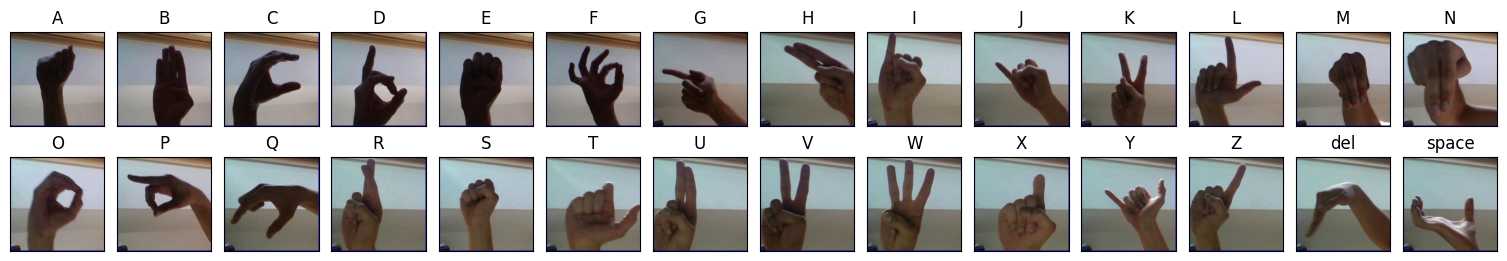

In [318]:
from PIL import Image
import torchvision.transforms.functional as TF


def load_image(image_path):
    image = Image.open(image_path)
    tensor = TF.to_tensor(image)
    tensor.unsqueeze_(0)
    return tensor


def plot_images(class_names):
    images = [
        f"./asl_alphabet_train/asl_alphabet_train/{class_name}/{class_name}2.jpg"
        for class_name in class_names if class_name != "nothing"
    ]
    print(images)

    images = [load_image(image) for image in images]

    _classNames = [class_name for class_name in class_names if class_name != "nothing"]

    fig, axs = plt.subplots(
        2, int(len(_classNames) / 2), constrained_layout=True, figsize=(15, 2.5)
    )

    for ax, image, name in zip(axs.flat, images, _classNames):
        ax.set(xticks=[], yticks=[])
        ax.set_title(name)
        ax.imshow(to_pil_image(image.squeeze(0)))

    fig.show()


plot_images(class_names)

## Data augmentation samples

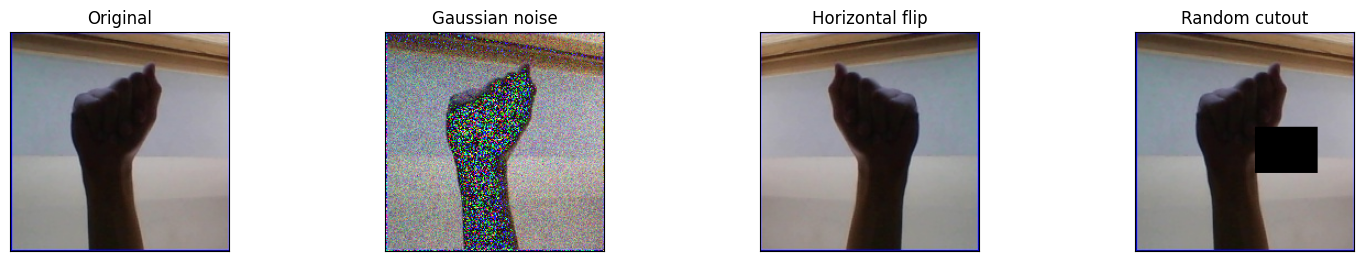

In [327]:
gauss = transforms.Compose([GaussNoise(0.1, 1)])
flip = transforms.Compose([transforms.RandomHorizontalFlip(p=1)])
cutout = transforms.Compose([transforms.RandomErasing(p=1, ratio=(0.5, 2), value=0, scale=(0.05, 0.1))])

image = Image.open("./asl_alphabet_train/asl_alphabet_train/A/A2.jpg")
tensor = TF.to_tensor(image)
tensor.unsqueeze_(0)

fig, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(15, 2.5))

for ax in axs.flat:
    ax.set(xticks=[], yticks=[])

axs[0].set_title("Original")
axs[0].imshow(image)

axs[1].set_title("Gaussian noise")
axs[1].imshow(to_pil_image(gauss(tensor).squeeze(0)))

axs[2].set_title("Horizontal flip")
axs[2].imshow(to_pil_image(flip(tensor).squeeze(0)))

axs[3].set_title("Random cutout")
axs[3].imshow(to_pil_image(cutout(tensor).squeeze(0)))

fig.show()